# Modelado

Importar librerías y lectura de datos

In [114]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import itertools

data = pd.read_csv('Datos_Madrid_tratados.csv')

In [2]:
data.dtypes

ID                       int64
Precio                   int64
Tipo                    object
N Habitaciones           int64
m2                       int64
Comentario              object
Zona                    object
Subzona                 object
Info                    object
Mas detalles            object
Comentario_lower        object
Mas detalles_lower      object
Info_lower              object
Planta                   int64
Cantidad de plantas      int64
Piscina                  int64
Ascensor                 int64
Garaje                   int64
N banos                  int64
Latitud                float64
Longitud               float64
Precio_m2              float64
dtype: object

Se transforma la columna tipo por one hot encoder

In [3]:
dummy_type = pd.get_dummies(data['Tipo'])
home_type_columns = dummy_type.columns
data = pd.concat([data, dummy_type], axis=1)

Se trabaja sólo con las columnas numéricas

In [4]:
data = data.select_dtypes(exclude=object).drop('ID', axis = 1)

## Primera nomalización sobe los datos
SE guardan los valores por los que se guía la normalización en factors_values

In [5]:
# Guardaremos un conjunto de validación para aplicar los factores de normalización al entrenamiento y luego normalizar
# la validación con los factores obtenidos
data_train = data.sample(frac=0.8,random_state=0)
data_valid = data.drop(data_train.index)


In [6]:
# Factores iniciales para aplicar la normalización

factors_values = data.agg(['max', 'min']).transpose()
factors_values['denom_factor'] = factors_values['max'] - factors_values['min']
factors_values['weight'] = 1
factors_values

,max,min,denom_factor,weight
Precio,1.500000e+07,35000.000000,1.496500e+07,1
N Habitaciones,4.100000e+01,0.000000,4.100000e+01,1
m2,2.517000e+03,16.000000,2.501000e+03,1
Planta,6.000000e+01,0.000000,6.000000e+01,1
Cantidad de plantas,3.000000e+00,1.000000,2.000000e+00,1
Piscina,1.000000e+00,0.000000,1.000000e+00,1
Ascensor,1.000000e+00,0.000000,1.000000e+00,1
Garaje,1.000000e+00,0.000000,1.000000e+00,1
N banos,4.100000e+01,0.000000,4.100000e+01,1
Latitud,4.159140e+01,40.341900,1.249500e+00,1


In [7]:
def normalize_column(df: pd.Series, factors_values):    
    return (df-factors_values['min'])/factors_values['denom_factor'] * factors_values['weight']

def normalize(df: pd.DataFrame, factors_values):
    for column in data:
        df[column] = normalize_column(df[column], factors_values.loc[column])
    return df

In [8]:
data_nr = normalize(data, factors_values)

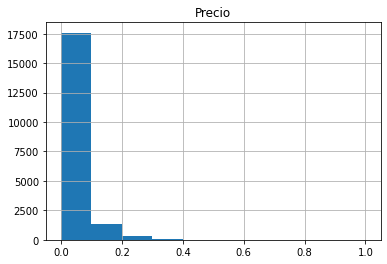

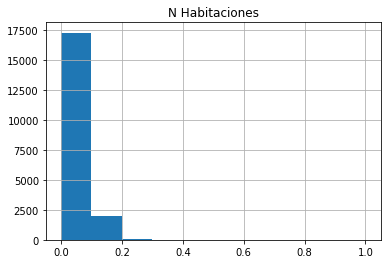

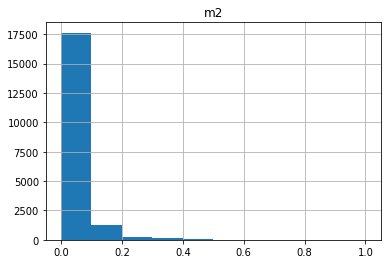

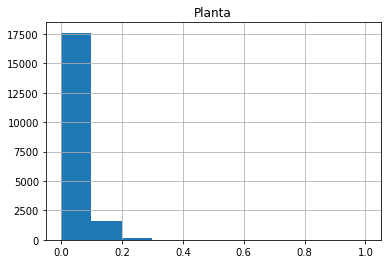

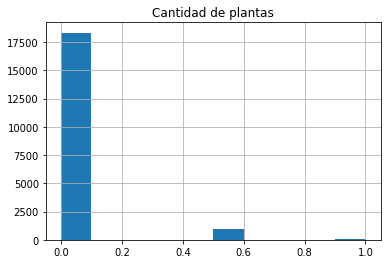

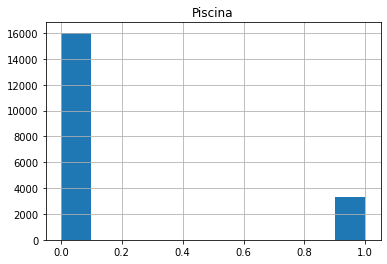

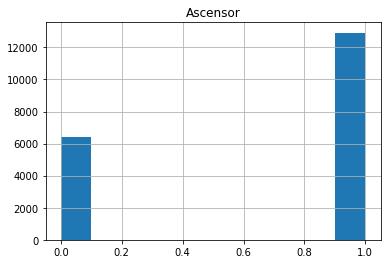

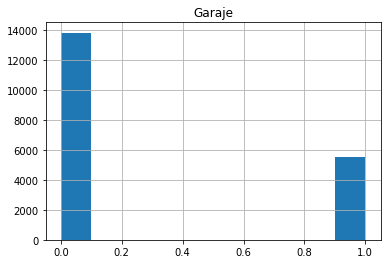

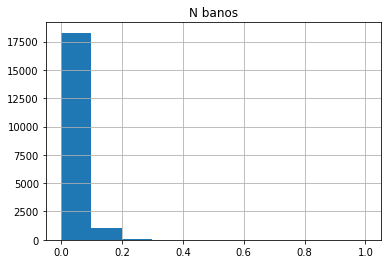

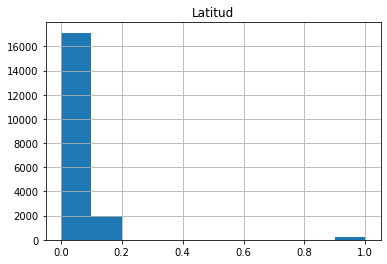

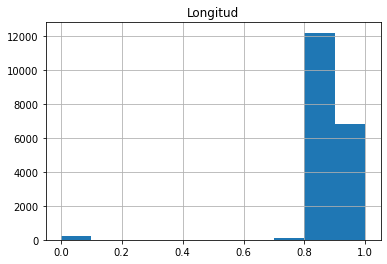

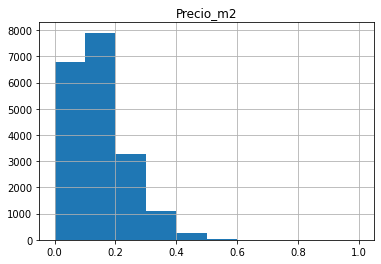

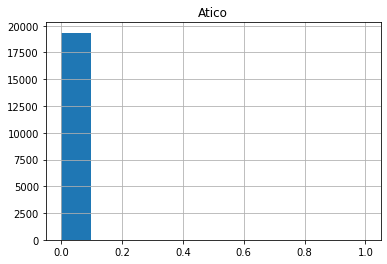

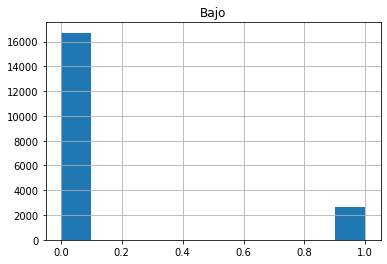

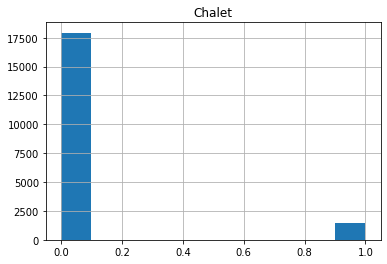

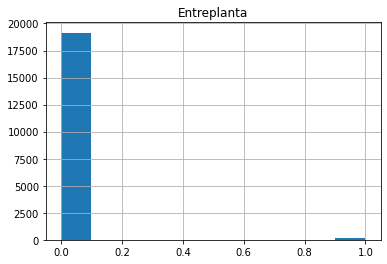

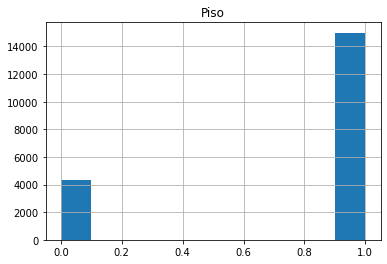

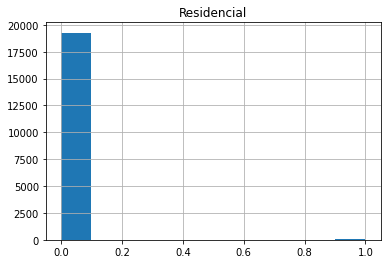

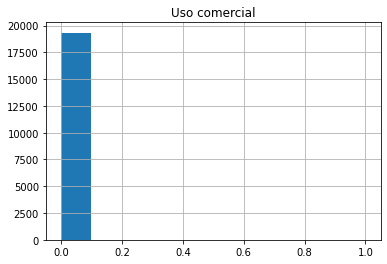

In [9]:
for column in data_nr.columns.tolist():
    data_nr[column].hist()
    plt.title(column)
    plt.show()
    

Fijas las variables features y predict

In [10]:
predict = 'Precio_m2'
fetures_exclude = ['Precio'] + [predict]
features = [column for column in data_nr if column not in fetures_exclude]
features

['N Habitaciones',
 'm2',
 'Planta',
 'Cantidad de plantas',
 'Piscina',
 'Ascensor',
 'Garaje',
 'N banos',
 'Latitud',
 'Longitud',
 'Atico',
 'Bajo',
 'Chalet',
 'Entreplanta',
 'Piso',
 'Residencial',
 'Uso comercial']

In [138]:
X_train, X_test, y_train, y_test = train_test_split(data_nr[features], data_nr[predict], test_size = 0.3)

In [105]:
knn=KNeighborsRegressor(n_neighbors = 15, weights = 'distance', metric = 'euclidean', algorithm = 'brute')
knn.fit(X_train,y_train)

KNeighborsRegressor(algorithm='brute', metric='euclidean', n_neighbors=15,
                    weights='distance')

In [106]:
y_pred_knn=knn.predict(X_test)

In [107]:
def check_solutions(X_train, X_test, knn, axis_x, axis_y):
    filter_test = X_test.sample(1)
    (filter_test_dictance, filter_test_neighbors) = knn.kneighbors(filter_test,return_distance=True)
    knn_pretty = X_train.iloc[filter_test_neighbors[0,:]]
    knn_dictance = filter_test_dictance[0,:]
    plt.scatter(filter_test[axis_x],filter_test[axis_y], c='b')
    plt.scatter(knn_pretty[axis_x],knn_pretty[axis_y], s=(1 + knn_dictance * 5000), c='r', alpha=0.5)
    plt.show()

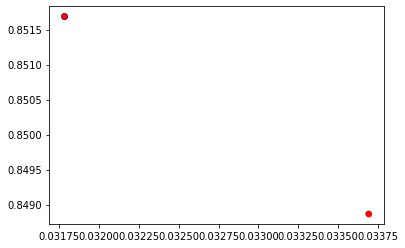

In [108]:
check_solutions(X_train, X_test, knn, 'Latitud', 'Longitud')

In [109]:
# Dato del que queremos predecir testigos
index_item = X_test.sample(1).index[0]
print(index_item)
(neighbor_distance, neighbor_positions) = knn.kneighbors(X_test.loc[[index_item]])
# Vecinos calculados
pd.concat([data_nr.loc[[index_item]], data_nr.loc[X_train.iloc[neighbor_positions[0]].index]], axis=0)

13118


,Precio,N Habitaciones,m2,Planta,Cantidad de plantas,Piscina,Ascensor,Garaje,N banos,Latitud,Longitud,Precio_m2,Atico,Bajo,Chalet,Entreplanta,Piso,Residencial,Uso comercial
13118,0.015369,0.073171,0.032787,0.016667,0.0,1.0,1.0,1.0,0.04878,0.031781,0.851689,0.083382,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14056,0.022319,0.073171,0.038784,0.016667,0.0,1.0,1.0,1.0,0.04878,0.026731,0.849651,0.106462,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14065,0.020314,0.073171,0.043982,0.016667,0.0,1.0,1.0,1.0,0.04878,0.026731,0.849651,0.082823,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13319,0.019713,0.073171,0.037585,0.033333,0.0,1.0,1.0,1.0,0.04878,0.031781,0.851689,0.095548,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14034,0.021049,0.073171,0.033986,0.033333,0.0,1.0,1.0,1.0,0.04878,0.026731,0.849651,0.114679,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14089,0.021049,0.073171,0.035186,0.033333,0.0,1.0,1.0,1.0,0.04878,0.026731,0.849651,0.110569,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13172,0.017247,0.073171,0.039584,0.033333,0.0,1.0,1.0,1.0,0.04878,0.031781,0.851689,0.076994,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12687,0.019846,0.073171,0.051180,0.016667,0.0,1.0,1.0,1.0,0.04878,0.033693,0.848867,0.066998,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13114,0.018710,0.073171,0.041583,0.033333,0.0,1.0,1.0,1.0,0.04878,0.031781,0.851689,0.080131,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13102,0.019713,0.073171,0.042383,0.033333,0.0,1.0,1.0,1.0,0.04878,0.031781,0.851689,0.083417,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Cálculo de puntuación en predicción de testigos, opción a realimentación de los clientes

In [129]:
# X es el dataset que queremos comprobar, data es el dataset donde comprobamos (el de entrenamiento y el nuevo concatenado)
def calculate_score(row: pd.Series, data: pd.DataFrame, conditions: dict):
    return ((data[conditions.keys()] - row[conditions.keys()]).abs() < conditions.values()).all(axis=1).mean()


def testigos_correctos(x:pd.DataFrame, data:pd.DataFrame, model, conditions = {'Latitud':0.1,'Longitud':0.1,'m2':0.25}): 
    
    # Añadimos o restamos a 1 el valor de porcentaje elegido para establecer testigos válidos en esos campos
    
    neighbors = model.kneighbors(x, return_distance=False)
    
    x["neighbors"] = list(neighbors)
    x["score"] = x.apply(lambda row: calculate_score(row.drop("neighbors"), data.iloc[row["neighbors"]], conditions), axis=1)
    
    return np.mean(list(x["score"]))

In [130]:
conditions = {'Latitud':0.1,'Longitud':0.1,'m2':0.25}
score = testigos_correctos(X_test.copy(), X_train, knn, conditions)


## Cálculo de parámetros

In [146]:
def total_factors_combinations(factor_list):
    list_tipo = ['Atico','Bajo','Chalet','Entreplanta','Piso','Residencial','Uso comercial']
    total_factors_combinations = []
    factors_combinations = itertools.product(*factor_list.values())
    for factors_combination in factors_combinations:
        factors_item = {}
        for column, factor in zip(factor_list, factors_combination):
            if column == "Tipo":
                for column_tipo in list_tipo:
                    factors_item[column_tipo] = factor
            else:
                factors_item[column] = factor
        total_factors_combinations.append(factors_item)
    return total_factors_combinations

def ranking_factors_combinations(X_train, X_test, factor_list, conditions_sample):
    factors_combinations = total_factors_combinations(factor_list)
    X_train_params = X_train.copy()
    X_test_params = X_test.copy()
    for factors_dict in factors_combinations:
        for column in factors_dict:
            X_train_params[column] = X_train[column]*factors_dict[column]
            X_test_params[column] = X_test[column]*factors_dict[column]
        knn = KNeighborsRegressor(n_neighbors = 15, weights = 'distance', metric = 'euclidean', algorithm = 'brute')
        knn.fit(X_train_params,y_train)
        score = testigos_correctos(X_test_params.copy(), X_train_params, knn, conditions_sample)
        factors_dict["score"] = score
    factors_combinations = sorted(factors_combinations, key=lambda item: item["score"], reverse=True)
    return factors_combinations

In [147]:
%%time
conditions_sample = {'Latitud':0.1,'Longitud':0.1,'m2':0.25}

factor_list = {}
factor_list['Latitud'] = [0.5,1,50]
factor_list['Longitud'] = [0.5,1,50]
factor_list['m2'] = [0.5,1,50]
factor_list['Tipo'] = [0.5,1,50]

combinations = ranking_factors_combinations(X_train, X_test, factor_list, conditions_sample)


# No tener en cuenta

In [17]:
def apply_factors(X, factors):
    for column in factors:
        X[column] = X[column]*factors[column]
    return X

def calculate_incremental_by_column(row, X_train, column, factors):
    factors_1 = factors.copy()
    factors_0 = factors.copy()
    factors_1[column] = factors_1[column] + 1
    factors_0[column] = factors_0[column] - 1
    closer = X_train.loc[row["closer"]].copy()
    farther = X_train.loc[row["farther"]].copy()
    result_closer = row.drop(["closer", "farther"]) - closer
    result_farther = row.drop(["closer", "farther"]) - farther
    result_closer_1 = sum(abs(result_closer*factors_1))
    result_closer_0 = sum(abs(result_closer*factors_0))
    result_closer = sum(abs(result_closer*factors))
    result_farther_1 = sum(abs(result_farther*factors_1))
    result_farther_0 = sum(abs(result_farther*factors_0))
    result_farther = sum(abs(result_farther*factors))
    result_1 = result_farther_1 - result_closer_1
    result_0 = result_farther_0 - result_closer_0
    result_orig = result_farther - result_closer
    if result_1 > result_orig:
        return 1
    elif result_0 > result_orig:
        return -1
    else:
        return 0

def calculate_incremental(X_train, relations, factors = None): 
    delta_incremental = 0.01
    if factors == None:
        factors = X_train.iloc[0].copy()
        factors[:] = 1
    for i in range(100):
        for column in X_train:
            factors_tmp = relations.apply(lambda row: calculate_incremental(row, X_train, column, factors), axis = 1)
            factors[column] = factors[column] + factors_tmp.value_counts()[0]*delta_incremental
    return factors

def print_prediction(y, X_train, predictions):
    X_result = X_train.loc[predictions[y.index[0]][0]]
    X_result["cost"] = predictions[y.index[0]][1]
    return pd.concat([y, X_result], axis = 0)

class KNNNearest():
    
    def __init__(self, k = 15):
        #################################
        # Inicialización de parámetros.
        self._k = k
        #################################
    
    def fit(self, X, X_relation = None):
        #################################
        # X_relation is a dataframe with the parameters of 3 points by columns
        # Creación del modelo.
        self._X = X
        self._X_numpy = X.to_numpy()
        if X_relation is not None:
            self._factors = calculate_incremental(self._X, X_relation)
        else:
            self._factors = X_train.copy().iloc[0]
            self._factors[:] = 1
        self._factors_numpy = self._factors.to_numpy()
        #################################
    
    def predict(self, y):
        test_numpy = y.to_numpy()
        predictions = {}
        for row, index in zip(test_numpy, y.index):
            cost =  (abs(self._X_numpy - row)*self._factors_numpy).sum(axis=1)
            cost = np.array([self._X.index, cost])
            cost = cost[:, cost[1, :].argsort()][:, :self._k]
            predictions[index] = cost
        return predictions

In [167]:
knn_tmp= KNNNearest()

In [168]:
knn_tmp.fit(X_train)

In [169]:
test = X_train.iloc[:2]
predictions = knn_tmp.predict(test)

(17,)
(13545, 17)
(17,)
(17,)
(13545, 17)
(17,)
       N Habitaciones        m2  Planta  Cantidad de plantas  Piscina  \
6371         0.048780  0.031188    0.05                  0.0      0.0   
16688        0.073171  0.041983    0.05                  0.5      0.0   

       Ascensor  Garaje  N banos   Latitud  Longitud  Atico  Bajo  Chalet  \
6371        1.0     0.0  0.04878  0.096759  0.887670    0.0   0.0     0.0   
16688       1.0     0.0  0.04878  0.027531  0.942385    0.0   0.0     0.0   

       Entreplanta  Piso  Residencial  Uso comercial  
6371           0.0   1.0          0.0            0.0  
16688          0.0   1.0          0.0            0.0  
{6371: array([[6.37100000e+03, 3.82100000e+03, 3.83300000e+03, 1.06040000e+04,
        6.45400000e+03, 5.78800000e+03, 3.57500000e+03, 6.75000000e+03,
        1.03660000e+04, 9.90200000e+03, 5.85900000e+03, 5.87100000e+03,
        6.49800000e+03, 6.35100000e+03, 4.39000000e+03],
       [0.00000000e+00, 1.48175473e-02, 1.64169076e-02,

In [184]:
print_prediction(test.iloc[0:1], X_train, predictions)

,N Habitaciones,m2,Planta,Cantidad de plantas,Piscina,Ascensor,Garaje,N banos,Latitud,Longitud,Atico,Bajo,Chalet,Entreplanta,Piso,Residencial,Uso comercial,cost
6371.0,0.04878,0.031188,0.050000,0.0,0.0,1.0,0.0,0.04878,0.096759,0.887670,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
6371.0,0.04878,0.031188,0.050000,0.0,0.0,1.0,0.0,0.04878,0.096759,0.887670,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
3821.0,0.04878,0.031188,0.050000,0.0,0.0,1.0,0.0,0.04878,0.092837,0.898565,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.014818
3833.0,0.04878,0.029588,0.050000,0.0,0.0,1.0,0.0,0.04878,0.092837,0.898565,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.016417
10604.0,0.04878,0.032387,0.050000,0.0,0.0,1.0,0.0,0.04878,0.082433,0.890100,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.017955
6454.0,0.04878,0.029588,0.033333,0.0,0.0,1.0,0.0,0.04878,0.096759,0.887670,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.018266
5788.0,0.04878,0.030388,0.066667,0.0,0.0,1.0,0.0,0.04878,0.088035,0.886886,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.026974
3575.0,0.04878,0.036385,0.050000,0.0,0.0,1.0,0.0,0.04878,0.082353,0.895822,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.027756
6750.0,0.04878,0.026789,0.033333,0.0,0.0,1.0,0.0,0.04878,0.103401,0.888689,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.028727
10366.0,0.04878,0.029588,0.050000,0.0,0.0,1.0,0.0,0.04878,0.073309,0.883750,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.028968


In [22]:
## Constructor del entrenamiento
relations = test.copy()
relations_orig = test.copy()
for i in range(5):
    closer_list = []
    farest_list = []
    for item in predict:
        closer_list.append(predict[item].index[i])
        farest_list.append(predict[item].index[i+1])
    relation_tmp = relations_orig.copy()
    relation_tmp.loc[:, "closer"] = closer_list
    relation_tmp.loc[:, "farest"] = farest_list
    if i > 0:
        relations = pd.concat([relations, relation_tmp], axis = 0, ignore_index = True)
    else:
        relations = relation_tmp.copy()

In [211]:
relations = {6371: [10604,10366,4390]}
for item in relations:
    list_sort = relations[item]
    entry_ref = X_train.loc[item].to_numpy()
    closer_list = np.array(list_sort[:-1]).reshape([2,1])
    farther_list = list_sort[1:]
    entry_ref = np.tile(entry_ref, (2,1))
    print(closer_list.shape)
    print(entry_ref.shape)
    entry_ref = np.append(entry_ref, closer_list, axis=1)
entry_ref

(2, 1)
(2, 17)


array([[4.87804878e-02, 3.11875250e-02, 5.00000000e-02, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 4.87804878e-02,
        9.67587035e-02, 8.87669515e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.06040000e+04],
       [4.87804878e-02, 3.11875250e-02, 5.00000000e-02, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 4.87804878e-02,
        9.67587035e-02, 8.87669515e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.03660000e+04]])

In [ ]:
relations = {}
for item in relations:
    list_sort = relations[item]
    entry_ref = X_train.loc[item]
    for i in range(5):
        closer_list = []
        farest_list = []
        for item in predict:
            closer_list.append(predict[item].index[i])
            farest_list.append(predict[item].index[i+1])
        relation_tmp = relations_orig.copy()
        relation_tmp.loc[:, "closer"] = closer_list
        relation_tmp.loc[:, "farest"] = farest_list
        if i > 0:
            relations = pd.concat([relations, relation_tmp], axis = 0, ignore_index = True)
        else:
            relations = relation_tmp.copy()

In [25]:
print(factors)

N Habitaciones         1.007
m2                     1.006
Planta                 1.007
Cantidad de plantas    1.010
Piscina                1.008
Ascensor               1.010
Garaje                 1.007
N banos                1.009
Latitud                1.004
Longitud               1.007
Atico                  1.010
Bajo                   1.008
Chalet                 1.010
Entreplanta            1.010
Piso                   1.009
Residencial            1.010
Uso comercial          1.010
Name: 13638, dtype: float64


In [24]:
#abs(self._X_cost - y_cost.loc[index])


In [ ]:
relations